# Проект по теме: Принятие решений в бизнесе

## Описание проекта

Перед нами данные крупного интернет-магазина. Вместе с отделом маркетинга был подготовиллен список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

### Описание данных

Таблица hypothesis:

- `Hypothesis` — краткое описание гипотезы;

- `Reach` — охват пользователей по 10-балльной шкале;

- `Impact` — влияние на пользователей по 10-балльной шкале;

- `Confidence` — уверенность в гипотезе по 10-балльной шкале;

- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Таблица orders:

- `transactionId` — идентификатор заказа;

- `visitorId` — идентификатор пользователя, совершившего заказ;

- `date` — дата, когда был совершён заказ;

- `revenue` — выручка заказа;

- `group` — группа A/B-теста, в которую попал заказ.


Таблица visitors:

- `date` — дата;

- `group` — группа A/B-теста;

- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


### Этапы работы

1. Чтение файла с данными и изучение общей информации
2. Приоритизация гипотез
3. Анализ A/B-теста
4. Вывод

## Изучение данных

Для работы с данными импортируем необходимые библиотеки:

In [72]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
import datetime as dt
import seaborn as sns

### Прочтение файлов и просмотр первых строк полученных данных

Прочитаем каждый имеющийся файл и посмотрим первые несколько строк для ознакомления

In [2]:
hypothesis = pd.read_csv('~/Desktop/project_files/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
orders = pd.read_csv('~/Desktop/project_files/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
visitors = pd.read_csv('~/Desktop/project_files/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Изучение общей информации по датафреймам

Перед началом исследования посмотрим общую информацию по имеющимся таблицам

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Исходя из общей информации видно, что пропусков в данных нет, однако во всех 3-х таблицах данные о дате хранятся в формате object, поэтому необходимо заранее изменить тип данных, также я для удобства переименую столбцы (таблица orders) и приведу их к нижнему регистру (таблица hypothesis).

## Предобработка данных

Изменим тип данных в столбцах с данными о времени в таблицах: visitors и orders

In [8]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Приведем к нижнему регистру столбцы таблицы hypothesis:

In [10]:
hypothesis.columns = hypothesis.columns.str.lower()

Переименуем названия столбцов в таблице orders:

In [11]:
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [12]:
orders.columns = ['order_id', 'user_id', 'date', 'revenue', 'group']

### Проверка на дубликаты

In [13]:
print('Количество дубликатов:', orders.duplicated().sum())

Количество дубликатов: 0


In [14]:
print('Количество дубликатов:', visitors.duplicated().sum())

Количество дубликатов: 0


### Проверка на пересечение пользователей между группами:

In [15]:
users_2_group = orders.query('group == "A"').merge(orders.query('group == "B"'), on='user_id')
len(users_2_group)

183

Таких пользователей (заказов) получилось 183, что составляет 15,3 % от всего количества. В целом ситуация с пользователями в двух группах неприятная и на реальном проекте стоит узнать у того, кто собирал данные, что пошло не так. В данном случае пользователей не так много, поэтому их можно оставить как есть, плюс мы не можем их полностью убрать из visitors.

## Приоритизация гипотез

### Применение фреймворка ICE

Для приоритизации гипотез воспользуемся 2-мя популярными способами: ICE и RICE

В ICE оценивается идея таким образом:

`Влияние` демонстрирует, насколько идея положительно повлияет на ключевой показатель, который вы пытаетесь улучшить.

`Легкость` реализации или простота — это оценка того, сколько усилий и ресурсов требуется для реализации этой идеи.

`Уверенность` демонстрирует, насколько вы уверены в оценках влияния и легкости реализации.

Значения в ICE оцениваются по шкале от 1 до 10, чтобы все факторы сбалансировано повлияли на итоговое число. 

Название RICE — это аббревиатура четырех факторов, которые используют для оценки: Reach, Impact, Confidence, Effort

In [16]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis_ice = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
pd.options.display.max_colwidth = 210
hypothesis_ice.round()

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Пятерка лидеров: 8, 0, 7, 6, 2 в порядке убывания значимости

### Применение фреймворка RICE

In [17]:
hypothesis['RICE'] = hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach'] / hypothesis['efforts']

hypothesis_rice = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
pd.options.display.max_colwidth = 210
hypothesis_rice.round()


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Здесь пятерка лидеров совпадает, но изменился порядок: 7, 2, 0, 6, 8. Данные изменения связаны с параметром reach (охват пользователей), очень важный параметр. Если посмотреть на имеющиеся данные, то у гипотезы 8 параметр reach равен 1, а у гипотезы 7 он равен 10. Получается, что гипотеза 7 охватывает не менее половины количество пользователей, а гипотеза 8 лишь небольшую часть пользователей. В данном случае бизнес самостоятельно принимает решение, какую гипотезу считать приоритетной.

## Анализ A/B-теста

### Построение графика кумулятивной выручки по группам

Прежде, чем строить график кумулятивной выручки по группам, для начала подготовим данные. Первое, мы сгруппируем таблицу заказов по дате и группе и избавимся от дубликатов.

In [18]:
dates_groups = orders[['date', 'group']].drop_duplicates()

In [19]:
orders.head()

,order_id,user_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Теперь получим строки таблицы orders, дата которых меньше или равна дате элемента из dates_groups, а группа теста равна группе из dates_groups, и агрегируем значения. Вычислим максимальную дату. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков, применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group'

In [20]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'order_id': 'nunique',
            'user_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

Проделаем аналогичную работу для посетителей интернет-магазина

In [21]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])



Объеденим полученные таблицы

In [22]:
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)


Переименуем столбцы в новой таблице

In [23]:
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Теперь выведем в отдельные таблицы кумулятивную выручку по дням для каждой группы

In [24]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

Строим график

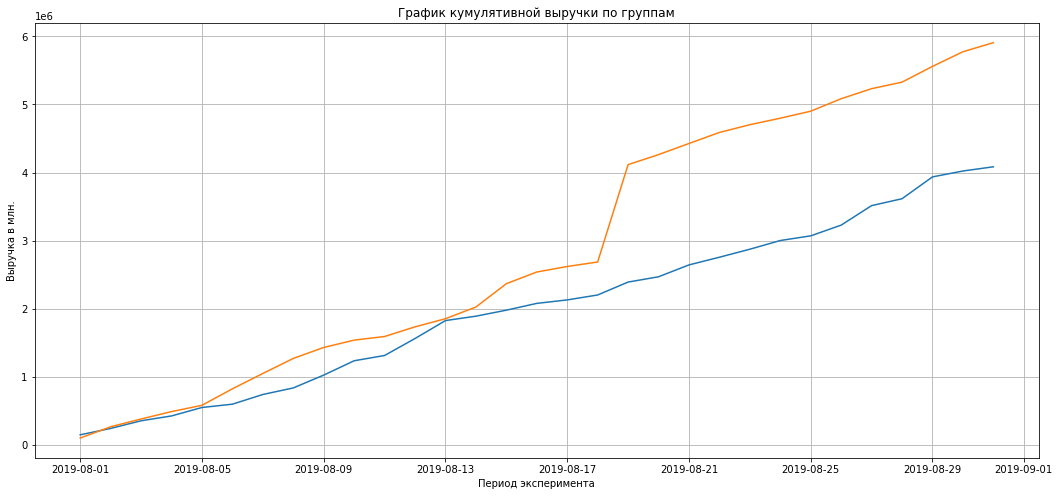

In [25]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Период эксперимента')
plt.ylabel('Выручка в млн.')
plt.grid()
plt.show()


Первые пять дней выручка в обеих группах увеличивалась равномерно, следующие 5 дней эксперимента выручка группы В была выше, после чего они сравнялись, далее 4 дня группа В также лидирует, резкий скачок выручки группы В случился с 17.08 и далее равномерно шел вверх. Группа А после 17.08 сильно отставала по выручке. Предположу, что это может быть связано с крупными заказами.

### Построение графика кумулятивного среднего чека по группам

Теперь посмотрим кумулятивный средний чек по группам, разделив выручку на количество заказов.

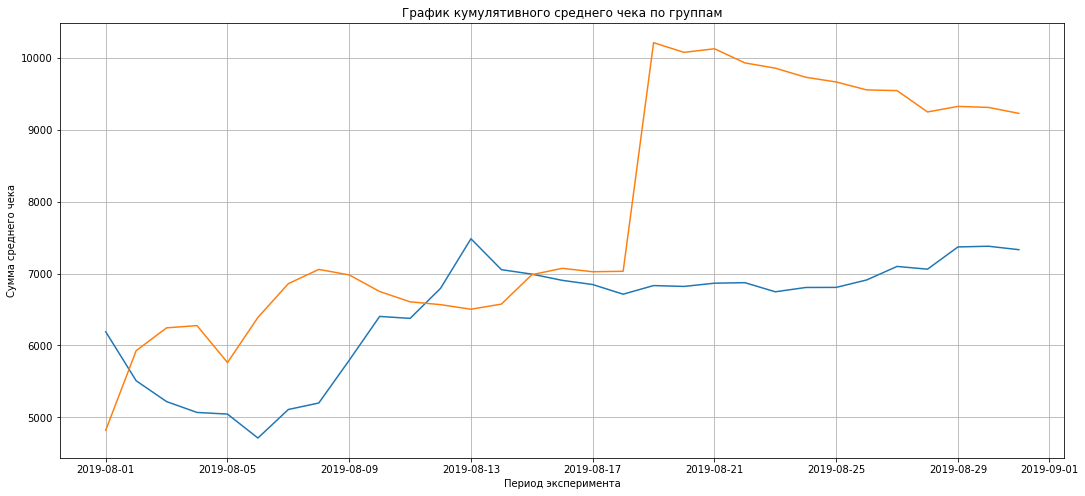

In [26]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Период эксперимента')
plt.ylabel('Сумма среднего чека')
plt.grid()
plt.show()


Опять же после 17 августа средний чек группы В резко увеличился, также связываю данный факт с крупным заказом.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

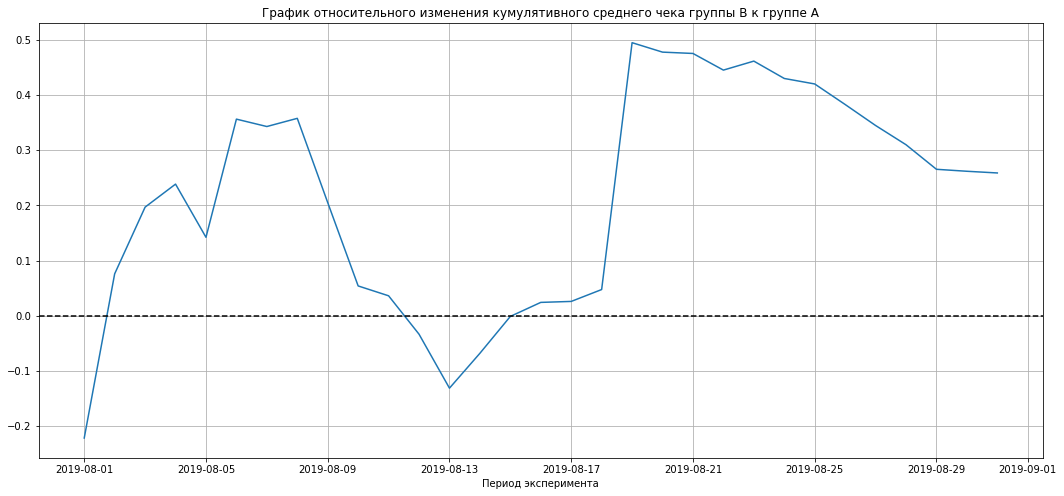

In [27]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Период эксперимента')
plt.grid()
plt.show()


В нескольких точках график различия между сегментами сильно скачет, значит в тесте точно есть крупные заказы и выбросы, позже с ними разберемся подробнее.

### Построение графика кумулятивной конверсии по группам

Теперь построим график кумулятивной конверсии по группам. Для начала разделим количество заказов на количество посетителей сайта и выведем данные в отдельные таблицы по группам.

In [28]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [29]:
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

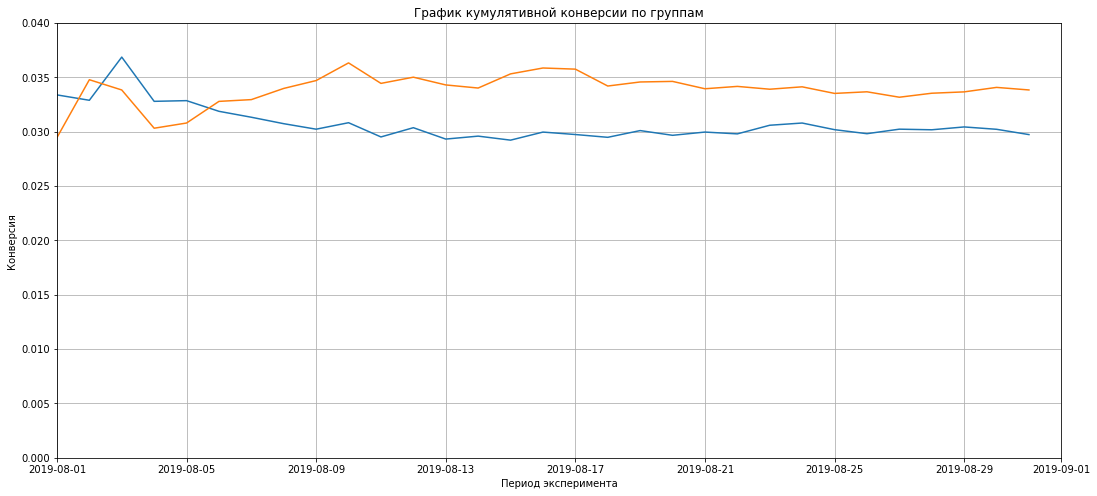

In [30]:
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Период эксперимента')
plt.ylabel('Конверсия')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.04])
plt.grid()
plt.show()

Примерно после 5 дня эксперимента конверсия группы В стала заметно выше конверсии группы А, обе так и зафиксировались до конца эксперимента.

### Построение графика относительного изменения кумулятивной конверсии группы B к группе A.

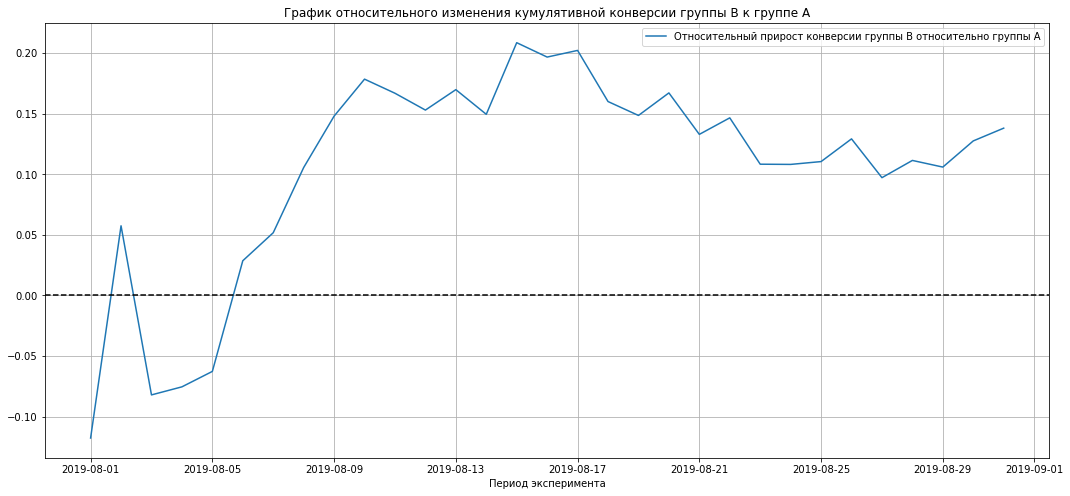

In [67]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Период эксперимента')
plt.axhline(y=0, color='black', linestyle='--')
#plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.2, 0.5]) 
plt.grid()

Группа B уверенно лидирует после 6-го дня эксперимента, с 22 августа конверсия стабилизировалась с небольшими колебаниями.

### Построение точечного графика количества заказов по пользователям и подсчет 95-й и 99-й перцентили количества заказов на пользователя

Для того, чтобы правильно оценить эксперимент, нам необходимо посомтреть, есть ли аномальные заказы и выбросы, оценить их количество и вдальнейшем учесть их. Для начала создадим таблицу, сгруппировав по количеству уникальных заказов на каждого пользователя.

In [32]:
orders.head()

,order_id,user_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [33]:
orders_by_users = (
    orders.groupby('user_id', as_index=False) 
    .agg({'order_id' : 'nunique',}) 
    .sort_values(by='order_id',ascending=False) 
)
display(orders_by_users.head(10))

,user_id,order_id
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Теперь построим гистограмму распредления по количеству заказов

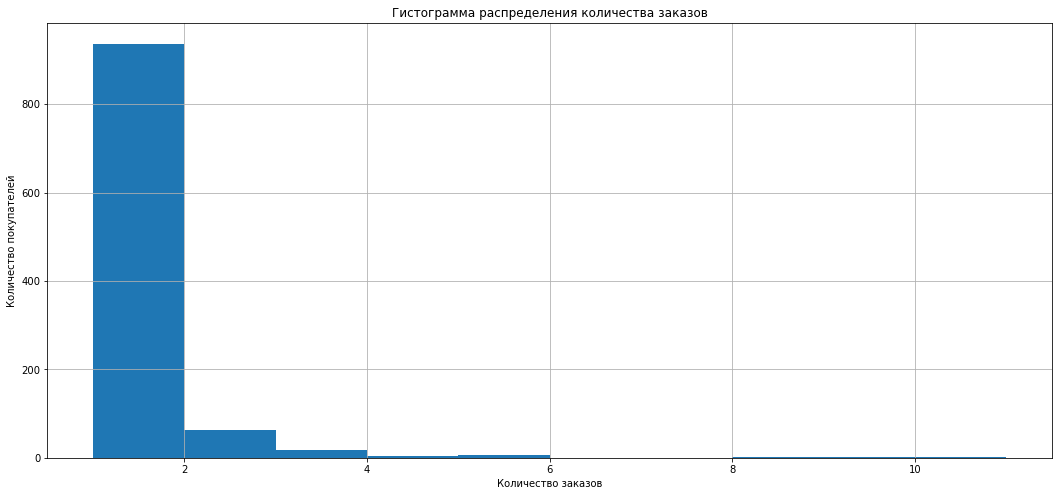

In [34]:
plt.hist(orders_by_users['order_id'])
plt.title('Гистограмма распределения количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество покупателей')
plt.grid()
plt.show()

Большинство покупателей оформляли заказ 1 раз, есть также небольшое количество покупателей, оформивших 2 заказа и скорее исключения - те покупатели, которые оформляли заказ более 3 раз: 6, 8 или даже 10  и выше заказов. Это скорее исключение, чем тенденция.

Теперь построим точечный график количества заказов по пользователям и посчитаем 95-й и 99-й перцентили количества заказов на пользователя

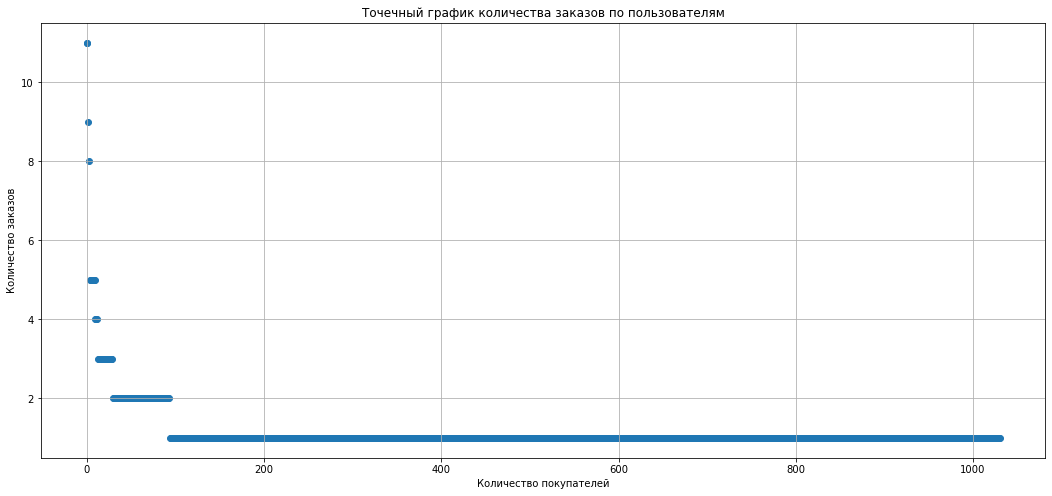

In [35]:
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['order_id'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество покупателей')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

In [36]:
print(np.percentile(orders_by_users['order_id'], [95, 99])) 

[2. 4.]


Исходя из полученных данных, не более 5 % всех покупателей оформляют свыше 2-х заказов и не более 1 % свыше 4 заказов. На точечном графике это отчетливо видно.

### Построение точечного графика стоимости заказов и подсчет 95-й и 99-й перцентили стоимости заказов

Теперь проделаем ту же работу по стоимости заказов. Важно: диапазон стоимости сознательно снизила до 100000 для наглядности.

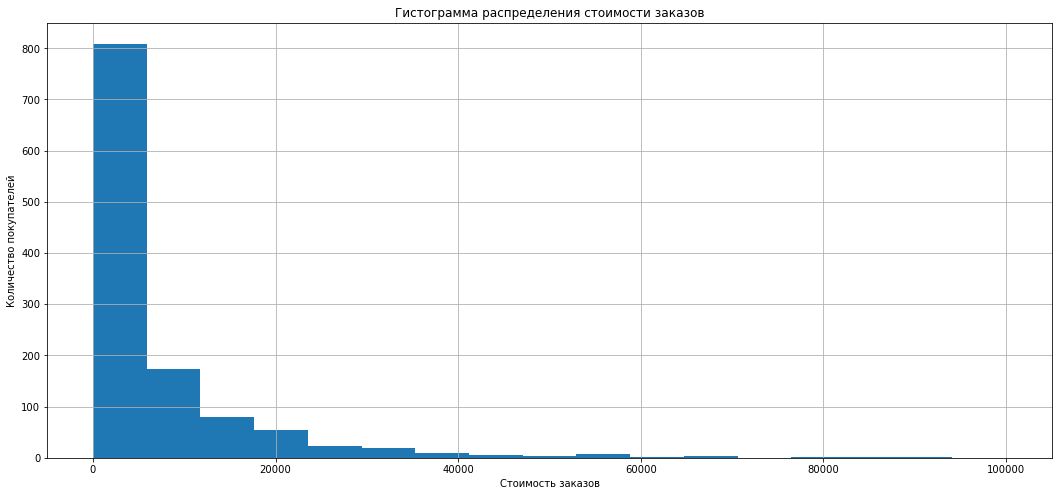

In [37]:
plt.hist(orders['revenue'], bins = 17, range = (0, 100000))
plt.title('Гистограмма распределения стоимости заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество покупателей')
plt.grid()
plt.show()

На графике видно, что большинство заказов на сумму примерно до 5-6 тысяч, стоимость свыше 40 тысяч уже редкость.

In [70]:
orders

,order_id,user_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [74]:
x_values = pd.Series(range(0, len(orders['revenue'])))

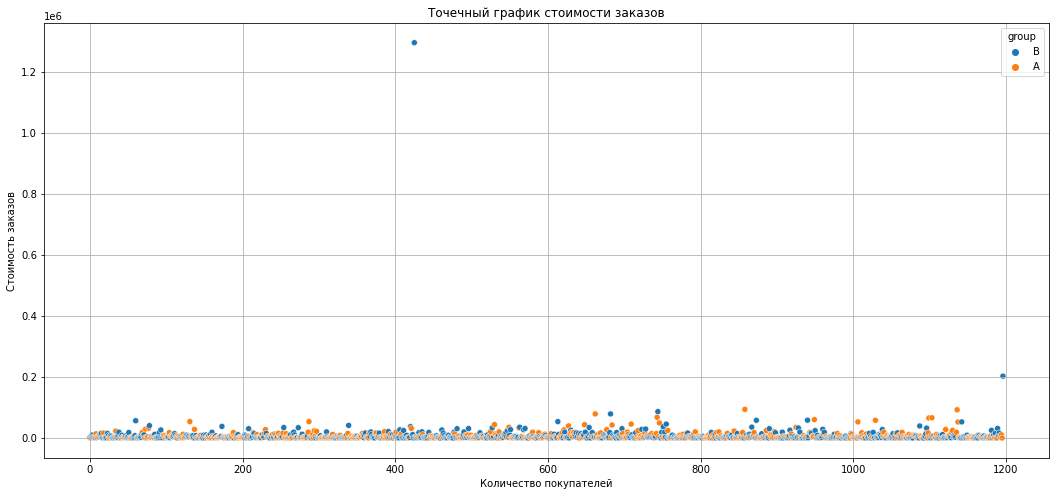

In [76]:
sns.scatterplot(data=orders, x=x_values, y='revenue', hue='group')
plt.title('Точечный график стоимости заказов')
plt.xlabel('Количество покупателей')
plt.ylabel('Стоимость заказов')
plt.grid()
plt.show()

График не выглядит наглядным, поэтому мы урежем стоимость покупки до 200 000, таким образом, избавимся от 2 выбросов:

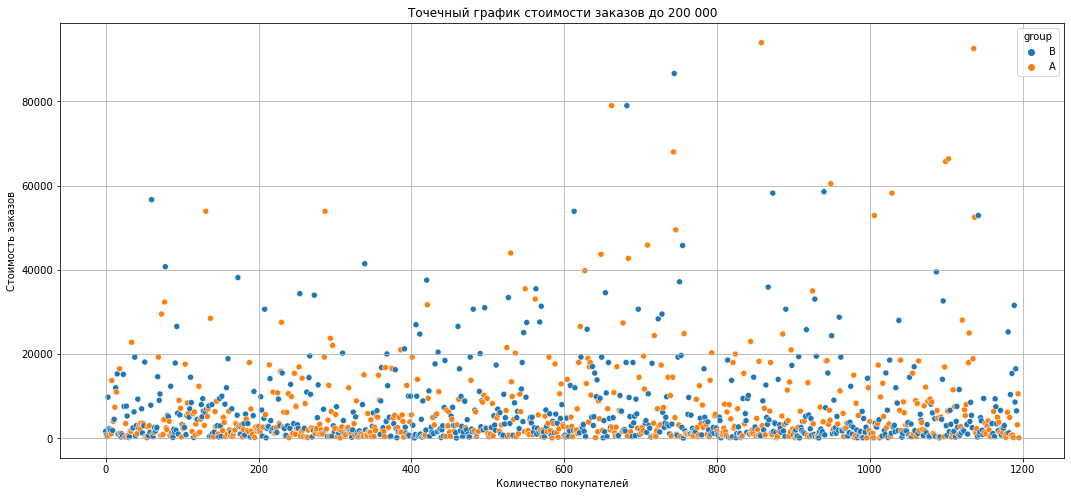

In [78]:
sns.scatterplot(data=orders.query('revenue < 200000'), x=x_values, y='revenue', hue='group')
plt.title('Точечный график стоимости заказов до 200 000')
plt.xlabel('Количество покупателей')
plt.ylabel('Стоимость заказов')
plt.grid()
plt.show()

In [39]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


На точечном графике выявился рекордсмен- заказ на сумму выше 1200000. Также, если обратить внимание на перцентили, то не более 5 % покупателей оформляют заказ на сумму свыше 28000, не более 1 % на сумму свыше 58 тысяч. Давайте посмотрим в какой группе были 2 крупных заказа, а именно свыше 200 тысяч и 1 млн. 200 тысяч.

In [40]:
display(orders.query('revenue > 200000'))

,order_id,user_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


Вот и ответ на предыдущие вопросы про резкий рост средней выручки и среднего чека группы В. Оба крупных заказа принадлежат этой группе, обязательно будем иметь это ввиду. Такие показатели сильно искажают результаты теста.Также, обратим внимания на даты этих заказов, они совпадают с ростом на графиках.

### Подсчет статистической значимости различий в конверсии между группами по «сырым» данным

Теперь приступим к подсчету статистической значимости различий в конверсии между группами по «сырым» данным. Для начала сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза (Н0): Конверсии группы А и В равны.

Альтернативная гипотеза (Н1): Конверсии группы А и В не равны.

alpha = 0.05 (уровень значимости)

Рассчитаем количество посетителей по дням для первой группы.

In [41]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

Далее, посчитаем кумулятивные данные о количестве пользователей в первой группе по дням.

In [42]:
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

Проделаем ту же работу по второй группе.

In [43]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

In [44]:
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

Следующий шаг: рассчитаем данные о количестве заказов, сумме выручке по дням для группы А

In [45]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

Рассчитаем данные о кумулятивном количестве заказов, сумме выручке по дням для группы А

In [46]:
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

Проделываем ту е работу со второй группой

In [47]:
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [48]:
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date','orders_cummulative_b','revenue_cummulative_b']

Объединяем все данные по датам в одну таблицу.

In [49]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

Далее, создадим 2 таблицы со столбцами 'user_id, 'orders', где для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

In [50]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

In [51]:
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

Объявляем переменные sample_a и sample_b - выборки с числом заказов каждого из пользователей по группам.

In [52]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
                     

In [53]:
sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применяем статистический критерий Манна-Уитни и считаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [54]:
alpha = 0.05
p_value = stats.mannwhitneyu(sample_a, sample_b)[1]

print('p-value:', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-value: 0.016792355056752608
Отвергаем нулевую гипотезу


In [55]:
print('Относительный прирост конверсии группы B к группе А равен:', sample_b.mean()/sample_a.mean()-1)

Относительный прирост конверсии группы B к группе А равен: 0.13807884655320146


p-value = 0.0168 меньше 0.05. Значит,статистически значимые различия в конверсии между группами есть. Относительный прирост конверсии группы B к группе А равен 13,8%.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Теперь рассмотрим  различия в среднем чеке между граппами. Также, сформулируем нулевую и алтернативную гипотезы.

Нулевая гипотеза (Н0): Различий в среднем чеке заказа между группами нет.

Альтернативная гипотеза (Н1): Различий в среднем чеке заказа между группами есть.

alpha = 0.05 (уровень значимости)

In [56]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('p-value:', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

p-value: 0.7292909855432458
Не получилось отвергнуть нулевую гипотезу


In [57]:
print('Относительный прирост среднего чека группы B к группе А равен:', orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
)


Относительный прирост среднего чека группы B к группе А равен: 0.2587136699126005


P-value больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом, средний чек группы B выше среднего чека группы A почти на 26 %. Также, мы помним, что это "сырые" данные. 

### Подсчет статистической значимости различий в конверсии между группами по «очищенным» данным

Ранее, в анализе, мы проанализировали аномальное количество заказов и и также стоимость заказов и пришли к выводу, что для очищенных данных подойдут заказы в количество 1 или 2, и по стоимости не выше 28000. Посмотрим, сколько у нас таких записей. 

Гипотезы остаются прежними:

Нулевая гипотеза (Н0): Конверсии группы А и В равны.

Альтернативная гипотеза (Н1): Конверсии группы А и В не равны.

alpha = 0.05 (уровень значимости)

In [58]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id'],
    ],
    axis=0,
)


In [59]:
users_with_expensive_orders = orders[orders['revenue'] > 28000]['user_id']

In [60]:
ab_normal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(ab_normal_users)

1099     148427295
18       199603092
928      204675465
23       237748145
37       249864742
           ...    
723     4009017467
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Name: user_id, Length: 74, dtype: int64


Всего 74, далее мы их не будем учитывать. Ниже фильтруем наши данные ипроводим тест заново.

In [61]:
sample_a_filter = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(ab_normal_users))]['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a['orders'])),name='orders')],axis=0)


In [62]:
sample_b_filter = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(ab_normal_users))]['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b['orders'])),name='orders')],axis=0)


In [63]:
p_value = stats.mannwhitneyu(sample_a_filter, sample_b_filter)[1]

print('p-value:', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.013042592743036745
Отвергаем нулевую гипотезу


In [64]:
print('Относительный прирост конверсии группы B к группе А равен:', sample_b_filter.mean()/sample_a_filter.mean()-1)

Относительный прирост конверсии группы B к группе А равен: 0.17270102073526417


На отфильтрованных данных результат не изменился, p-value меньше 0,05 и статистические различия есть и относительный прирост конверсии группы B к группе А теперь составляет 17,3%

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Гипотезы остаются прежними:

Нулевая гипотеза (Н0): Различий в среднем чеке заказа между группами нет.

Альтернативная гипотеза (Н1): Различий в среднем чеке заказа между группами есть.

alpha = 0.05 (уровень значимости)

In [65]:
p_value = (
    stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['user_id'].isin(ab_normal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['user_id'].isin(ab_normal_users)),
                )
            ]['revenue'],
        )[1]
)

print('p-value:', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.738481751314565
Не получилось отвергнуть нулевую гипотезу


In [66]:
print(
        'Относительный прирост среднего чека группы B к группе А равен:',
    orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['user_id'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['user_id'].isin(ab_normal_users)),
            )
        ]['revenue'].mean()
        - 1
    )

Относительный прирост среднего чека группы B к группе А равен: -0.019624288331982598


Мы не можем отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. При этом, после очищения данных, средний чек группы В примерно на 2 % ниже группы А.

## Общий вывод

Мы анализировали данные за 30 дней крупного интернет-магазина. Необходимо было приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Перед началом анализа, мы предобработали данные: переименовали столбцы, привели их к нижнему регистру и изменили тип данных во всех трех таблицах в столбцах с данными о дате.

Для приоритизации гипотез воспользовались 2-мя популярными способами: ICE и RICE. В первом случае пятерка лидеров: 

гипотезы 8, 0, 7, 6, 2 в порядке убывания значимости

При использовании второго способа пятерка лидеров совпадает, но изменился порядок: 7, 2, 0, 6, 8. 

Данные изменения связаны с параметром reach (охват пользователей), очень важный параметр. Если посмотреть на имеющиеся данные, то у гипотезы 8 параметр reach равен 1, а у гипотезы 7 он равен 10. Получается, что гипотеза 7 охватывает не менее половины количество пользователей, а гипотеза 8 лишь небольшую часть пользователей. В данном случае бизнес самостоятельно принимает решение, какую гипотезу считать приоритетной.

После этого мы построили график кумулятивной выручки по группам, который показал, что первые пять дней выручка в обеих группах увеличивалась равномерно, следующие 5 дней эксперимента выручка группы В была выше, после чего они сравнялись, далее 4 дня группа В также лидирует, резкий скачок выручки группы В случился с 17.08 и далее равномерно шел вверх. Группа А после 17.08 сильно отставала по выручке. Предположу, что это может быть связано с крупными заказами.

Также, построили график кумулятивного среднего чека по группам, который показал, что после 17 августа средний чек группы В резко увеличился.

Вместе с тем, мы построили график относительного изменения кумулятивного среднего чека группы B к группе A, в котором в нескольких точках график различия между сегментами сильно скачет, значит в тесте точно есть крупные заказы и выбросы.

Исходя из графика кумулятивной конверсии по группам, можно сказать, что примерно после 5 дня эксперимента конверсия группы В стала заметно выше конверсии группы А, обе так и зафиксировались до конца эксперимента.

Исходя из графика относительного изменения кумулятивной конверсии группы B к группе A, группа B уверенно лидирует после 6-го дня эксперимента.

После первых выводов, мы построили точечные графики количества заказов по пользователям и стоимости заказов, а также посчитали 95-й и 99-й перцентили для каждого показателя соответственно. Краткие выводы:

1. Большинство покупателей оформляли заказ 1 раз, есть также небольшое количество покупателей, оформивших 2 заказа и скорее исключения - те покупатели, которые оформляли заказ более 3 раз: 6, 8 или даже 10  и выше заказов. Это скорее исключение, чем тенденция.
2. Не более 5 % всех покупателей оформляют свыше 2-х заказов и не более 1 % свыше 4 заказов. На точечном графике это отчетливо видно.
3. Имеется заказ на сумму выше 1200000. Также, если обратить внимание на перцентили, то не более 5 % покупателей оформляют заказ на сумму свыше 28000, не более 1 % на сумму свыше 58 тысяч. 
4. В группе "В" были 2 крупных заказа, а именно свыше 200 тысяч и 1 млн. 200 тысяч, что является аномально высокими показателями, они определенно повлияли на результаты исследования.

И в конце, мы применили статистический критерий Манна-Уитни и определили статистическую значимость различий в конверсии между группами по «сырым» данным, в результате p-value = 0.0168. Значит,статистически значимые различия в конверсии между группами есть. Относительный прирост конверсии группы B к группе А равен 13,8%.

После подсчета статистической значимости различий в среднем чеке заказа между группами по «сырым» данным, мы определили, что 
P-value = 0.729. P-value больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом, средний чек группы B выше среднего чека группы A почти на 26 %.

Ранее, в анализе, мы проанализировали аномальное количество заказов и и также стоимость заказов и пришли к выводу, что для очищенных данных подойдут заказы в количество 1 или 2, и по стоимости не выше 28000. Отфильтровав данные, мы получили следующие результаты:
1. На отфильтрованных данных результат статистической значимости различий в конверсии между группами не изменился, p-value = 0.013 и оно меньше 0,05. Следует, что статистические различия есть и относительный прирост конверсии группы B к группе А теперь составляет 17,3%.
2. Мы не можем отвергать нулевую гипотезу и считать, что в среднем чеке есть различия (p-value = 0.738). При этом, после очищения данных, средний чек группы В примерно на 2 % ниже группы А.

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.

Рекомендации бизнесу:

Хотя и средний чек в группах статистически не отличается, при этом конверсия группы B на 17,3% больше, чем у группы A, это говорит о том, что пользователи группы B чаще совершают покупки. Моя рекомендация: остановить тест, признать его успешным.
